In [1]:
# Install RDKit. Takes 2-3 minutes
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

--2020-06-18 04:15:08--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2020-06-18 04:15:08--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88867207 (85M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  84.75M   165MB/s    in 0.5s    

2020-06-18 04:15:08 (165 MB/s) - ‘Miniconda3-latest-Linux

In [2]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

from rdkit import Chem
from rdkit.Chem import AllChem
from collections import defaultdict
from rdkit.Chem import rdFMCS
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
import numpy as np
import random
from rdkit import rdBase

Before you start, here are two pages, you should go through:
* [RDKIT](https://www.rdkit.org/docs/GettingStartedInPython.html)
* [SMARTS](https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html)

In [110]:
def checking(mol, action_smart):
  rxn = AllChem.ReactionFromSmarts(action_smart)
  return rxn.RunReactants((mol,))[0][0]


In [130]:
# This function checks if the bonds & valencies make sense
def mol_sanity(mol):
  try:
    smiles = Chem.MolToSmiles(mol)
    Chem.SanitizeMol(mol)
    return True
  except:
    return False

# Function to ensure atoms within rings are acceptable
def ring_sanity(mol):
  if not mol.HasSubstructMatch(Chem.MolFromSmarts('[R]')):
    return True
  
  # no consecutive double bonds in a ring
  ring_allene = mol.HasSubstructMatch(Chem.MolFromSmarts('[R]=[R]=[R]'))
  
  # No more than 6 atoms in a ring
  cycle_list = mol.GetRingInfo().AtomRings() 
  big_cycle = max([ len(j) for j in cycle_list ]) > 6

  # No double bonds in small rings
  double_bond_small_ring = mol.HasSubstructMatch(Chem.MolFromSmarts('[r3,r4]=[r3,r4]'))
  
  return not ring_allene and not big_cycle and not double_bond_small_ring


# Use this for making a carbon backbone with other elements
def change_atom(mol,atom):
  smarts = '[C:1]>>[#'+str(atom)+':1]'
  rxn = AllChem.ReactionFromSmarts(smarts)
  new_mol = rxn.RunReactants((mol,))

  m = new_mol[0][0]

  if mol_sanity(m) and ring_sanity(m):
    return m


# How do we modify existing bonds - return SMARTS for the same
def mutate_bonds_smarts():
  choices = ['[*:1]!-[*:2]>>[*:1]-[*:2]','[*;!H0:1]-[*;!H0:2]>>[*:1]=[*:2]',
             '[*:1]#[*:2]>>[*:1]=[*:2]','[*;!R;!H1;!H0:1]~[*:2]>>[*:1]#[*:2]']
  return np.random.choice(choices, p=[0.25,0.25,0.25,0.25])


# How do we modify / introduce rings - return SMARTS for the same
def mutate_rings_smarts():
  choices = ['[*;!r;!H0:1]~[*;!r:2]~[*;!r;!H0:3]>>[*:1]1~[*:2]~[*:3]1',
             '[*;!r;!H0:1]~[*!r:2]~[*!r:3]~[*;!r;!H0:4]>>[*:1]1~[*:2]~[*:3]~[*:4]1',
             '[*;!r;!H0:1]~[*!r:2]~[*:3]~[*:4]~[*;!r;!H0:5]>>[*:1]1~[*:2]~[*:3]~[*:4]~[*:5]1',
             '[*;!r;!H0:1]~[*!r:2]~[*:3]~[*:4]~[*!r:5]~[*;!r;!H0:6]>>[*:1]1~[*:2]~[*:3]~[*:4]~[*:5]~[*:6]1'] 

  return np.random.choice(choices,p=[0.05,0.05,0.45,0.45])


def mutate(mol):
  Chem.Kekulize(mol,clearAromaticFlags=True)
  for i in range(20):
    smarts = np.random.choice([mutate_bonds_smarts(), mutate_rings_smarts()]) 
    
    rxn = AllChem.ReactionFromSmarts(smarts)
    mol_trial = rxn.RunReactants((mol,))
    
    for m in mol_trial:
      m = m[0]
      if mol_sanity(m) and ring_sanity(m):
        return m
    
  return None

RDKit ERROR: [07:46:32] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [07:46:32] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [07:46:32] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [07:46:32] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [07:46:32] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [07:46:32] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [07:46:32] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [07:46:32] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [07:46:32] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [07:46:32] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [07:46:32] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [07:46:32] Explicit valence for atom # 1 

C12H9N C12H9N


RDKit ERROR: [07:46:32] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [07:46:32] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [07:46:32] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [07:46:32] Explicit valence for atom # 1 C, 5, is greater than permitted


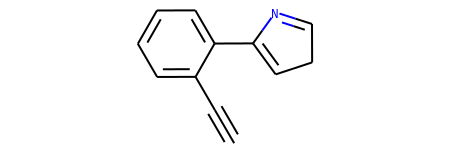

In [131]:
target_mol = Chem.MolFromSmiles('c1ccc2c(c1)c3ccccc3[nH]2')
target_formula = CalcMolFormula(target_mol)
n_atoms = target_mol.GetNumAtoms()

# Generate a carbon back-chain
mol = Chem.MolFromSmiles(n_atoms*'C')

atoms = [atom.GetAtomicNum() for atom in target_mol.GetAtoms()]
d = {item:atoms.count(item) for item in atoms}
del d[6]
for atom in d:
  for i in range(d[atom]):
    mol = change_atom(mol,atom)

start_mol = Chem.Mol(mol) 

n_tries = 500
for _ in range(n_tries):
  if target_formula == CalcMolFormula(mol):
    break
  
  mol = mutate(mol)
  if not mol:
    mol = Chem.Mol(start_mol)

print(target_formula, CalcMolFormula(mol))
mol